In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn import set_config

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from lifelines import CoxPHFitter, WeibullAFTFitter
from lifelines.utils import concordance_index

In [4]:
 # load the df
filename = './artifacts/df_model.pkl'
df_model = pickle.load(open(filename, 'rb'))
df_model.rename(columns={'t_new':'t'},inplace=True)

In [5]:
X = df_model[['AdmissionScoreTotal','language_exam_available','EnrollmentCredit','Completed','SubjectTakenCount','EntryValue']]
y = np.array(df_model[['StatusId','t']].to_records(index=False))

Check distribution 

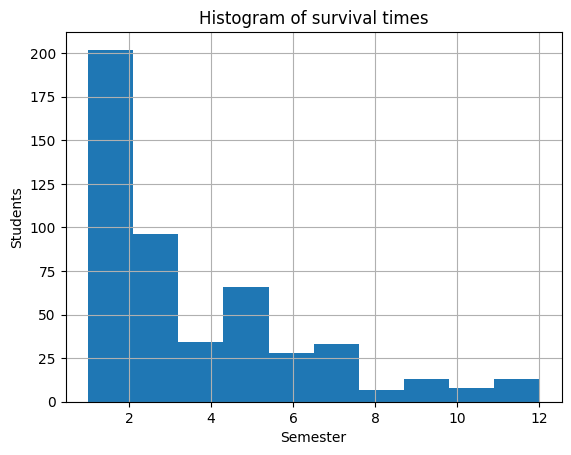

In [6]:
T = df_model["t"]
plt.hist(T)
plt.grid()
plt.title('Histogram of survival times')
plt.xlabel('Semester')
plt.ylabel('Students')
plt.show()

Kaplan-Meier

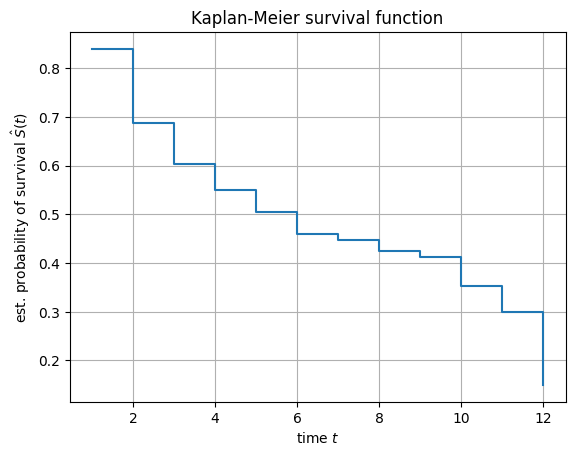

In [7]:
time, survival_prob = kaplan_meier_estimator(y["StatusId"], y["t"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.grid()
plt.title('Kaplan-Meier survival function')
plt.show()

Modeling

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

COX PH

In [9]:
df_train = pd.concat([pd.DataFrame.from_records(y_train).set_index(X_train.index),X_train], axis=1)
df_test = pd.concat([pd.DataFrame.from_records(y_test).set_index(X_test.index),X_test], axis=1)

In [10]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col = 't', event_col = 'StatusId')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 375 total observations, 197 right-censored observations>
             duration col = 't'
                event col = 'StatusId'
      baseline estimation = breslow
   number of observations = 375
number of events observed = 178
   partial log-likelihood = -798.42
         time fit was run = 2023-05-08 18:09:26 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
AdmissionScoreTotal      -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
language_exam_available   0.88       2.40       0.42             0.06             1.69                 1.06                 5.44
EnrollmentCredit         -0.04       0.96       0.02            -0.08            -0.01                 0.93                 0.99
Completed                -1.25       0.29       0.71            -2.64             0.13                 0.07                 1.14
SubjectTakenCount        -5.16       0.01       0.61            -6.36            -3.96                 0.00                 0.02
EntryValue               -1.24       0.29       0.24            -1.71            -0.76                 0.18                 0.47

                          cmp to     z      p   -log2(p)
covariate                                               
AdmissionScoreTotal         0.00 -2.30   0.02       5.52
language_exam_available     0.00  2.10   0.04       4.82
EnrollmentCredit            0.00 -2.80   0.01       7.62
Completed                   0.00 -1.78   0.08       3.73
SubjectTakenCount           0.00 -8.43 <0.005      54.68
EntryValue                  0.00 -5.10 <0.005      21.51
---
Concordance = 0.87
Partial AIC = 1608.84
log-likelihood ratio test = 311.31 on 6 df
-log2(p) of ll-ratio test = 210.98

In [11]:
y_pred_hazards = cph.predict_partial_hazard(X_test)

In [12]:
concordance_index(y_test['t'], -y_pred_hazards)

0.7161430119176598

Random survival forest

In [13]:
n_estim = [100,500,1000,2000]
min_samples_split_list = [3,10,15,20]
min_samples_leaf_list = [3,10,15,20]

n_estim_df = []
min_split_df = []
min_leaf_df = []
c_indexes = []

for estimators in n_estim:
    for sample_split in min_samples_split_list:
        for sample_leaf in min_samples_leaf_list:

            rsf = RandomSurvivalForest(n_estimators=estimators,
                                    min_samples_split=sample_split,
                                    min_samples_leaf=sample_leaf,
                                    n_jobs=-1,
                                    random_state=42)
            rsf.fit(X_train, y_train)
            c_index = rsf.score(X_test, y_test)

            n_estim_df.append(estimators)
            min_split_df.append(sample_split)
            min_leaf_df.append(sample_leaf)
            c_indexes.append(c_index)

df_rsf_eval = pd.DataFrame({'n_estimators':n_estim_df,
                            'min_samples_split':min_split_df,
                            'min_samples_leaf':min_leaf_df,
                            'c_index':c_indexes})

KeyboardInterrupt: 

In [49]:
df_rsf_eval.sort_values(by='c_index', ascending=False)

,n_estimators,min_samples_split,min_samples_leaf,c_index
0,100,3,3,0.857511
16,500,3,3,0.856223
32,1000,3,3,0.856223
48,2000,3,3,0.848927
62,2000,20,15,0.830901
...,...,...,...,...
8,100,15,3,0.821245
13,100,20,10,0.820815
9,100,15,10,0.820815
1,100,3,10,0.820815


AFT

In [51]:
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(df_train, duration_col='t', event_col='StatusId')
weibull_aft.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 375 total observations, 197 right-censored observations>
             duration col = 't'
                event col = 'StatusId'
   number of observations = 375
number of events observed = 178
           log-likelihood = -380.209
         time fit was run = 2023-05-08 17:16:21 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                       
lambda_ AdmissionScoreTotal      0.003      1.003      0.001            0.001            0.005                1.001                1.005
        Completed                0.399      1.490      0.307           -0.203            1.000                0.816                2.719
        EnrollmentCredit         0.024      1.025      0.007            0.010            0.039                1.010                1.040
        EntryValue               0.548      1.730      0.110            0.333            0.763                1.395                2.145
        SubjectTakenCount        2.806     16.551      0.234            2.347            3.266               10.454               26.204
        language_exam_available -0.337      0.714      0.183           -0.696            0.023                0.499                1.023
        Intercept               -4.636      0.010      0.431           -5.482           -3.791                0.004                0.023
rho_    Intercept                0.799      2.223      0.060            0.682            0.916                1.978                2.499

                                  cmp to       z       p   -log2(p)
param   covariate                                                  
lambda_ AdmissionScoreTotal        0.000   2.480   0.013      6.252
        Completed                  0.000   1.299   0.194      2.366
        EnrollmentCredit           0.000   3.257   0.001      9.796
        EntryValue                 0.000   4.997 <0.0005     20.714
        SubjectTakenCount          0.000  11.972 <0.0005    107.310
        language_exam_available    0.000  -1.835   0.066      3.912
        Intercept                  0.000 -10.748 <0.0005     87.089
rho_    Intercept                  0.000  13.375 <0.0005    133.118
---
Concordance = 0.872
AIC = 776.418
log-likelihood ratio test = 327.830 on 6 df
-log2(p) of ll-ratio test = 222.748

In [68]:
weibull_aft.score(df_test, scoring_method='concordance_index')

0.8527896995708154

Final model

In [131]:
df_rsf_eval.sort_values(by='c_index', ascending=False).head(5)

,n_estimators,min_samples_split,min_samples_leaf,c_index
0,100,3,3,0.857511
16,500,3,3,0.856223
32,1000,3,3,0.856223
48,2000,3,3,0.848927
62,2000,20,15,0.830901


In [7]:
rsf = RandomSurvivalForest(n_estimators=100,
                        min_samples_split=3,
                        min_samples_leaf=3,
                        n_jobs=-1,
                        random_state=42)

rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_split=3, n_jobs=-1, random_state=42)

In [8]:
risk_scores = rsf.predict(X_test)

In [14]:
survival_func = rsf.predict_survival_function(X_test, return_array=True)

In [132]:
# Save df
filename = './artifacts/random_survival_forest.pkl'
pickle.dump(rsf, open(filename, 'wb'))

Tests

In [79]:
x_new = df_test[~df_test['StatusId']].head().iloc[:,2:]
x_new

,AdmissionScoreTotal,language_exam_available,EnrollmentCredit,Completed,SubjectTakenCount,EntryValue
11359,432.0,0,34.333333,1.000000,1.000000,4.932039
3853,321.0,0,15.818182,0.758621,1.293103,2.856322
12172,348.0,0,9.000000,0.666667,1.166667,2.444444
11776,356.0,0,25.666667,0.720000,1.200000,2.675325
13431,449.0,0,30.000000,1.000000,1.000000,4.466667


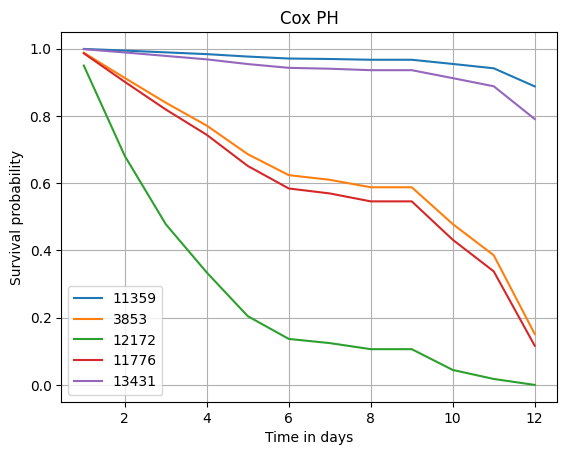

In [129]:
surv = cph.predict_survival_function(x_new)
surv.plot()
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.title('Cox PH')
plt.show()

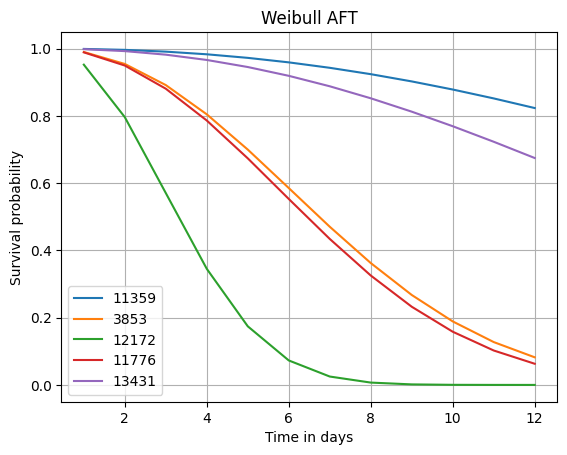

In [128]:
surv = weibull_aft.predict_survival_function(x_new)
surv.plot()
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.title('Weibull AFT')
plt.show()

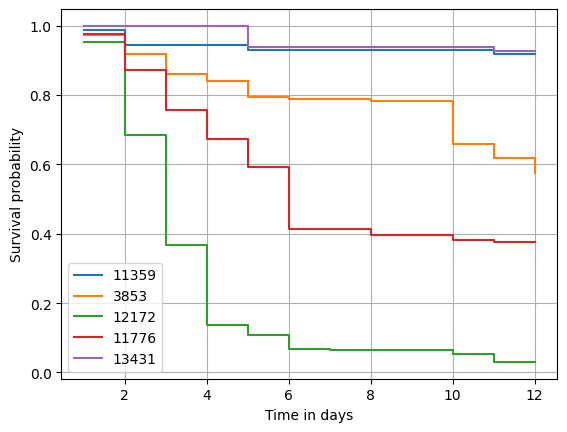

In [127]:
surv = rsf.predict_survival_function(x_new, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=x_new.iloc[i:i+1,:].index[0])
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.show()